# Ensemble Level LSTM Model

In [1]:
from __future__ import print_function
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os
import datetime
import pickle
from sklearn import datasets, metrics, cross_validation
from urllib import urlretrieve
import matplotlib.pyplot as plt
import random
from itertools import permutations

URL = "https://github.com/anucc/metatone-analysis/raw/master/metadata/"
PICKLE_FILE = "metatone_performances_dataframe.pickle"

if not os.path.exists(PICKLE_FILE):
    urlretrieve(URL + PICKLE_FILE, PICKLE_FILE)

with open(PICKLE_FILE, 'rb') as f:
        metatone_dataset = pickle.load(f)
        
## Int values for Gesture codes.
NUMBER_GESTURES = 9
GESTURE_CODES = {
    'N': 0,
    'FT': 1,
    'ST': 2,
    'FS': 3,
    'FSA': 4,
    'VSS': 5,
    'BS': 6,
    'SS': 7,
    'C': 8}

vocabulary_size = len(GESTURE_CODES)

In [12]:
## Isoloate Individual Performances
improvisations = metatone_dataset[
    (metatone_dataset["performance_type"] == "improvisation") &
    (metatone_dataset["performance_context"] != "demonstration")]
gesture_data = improvisations['gestures']
individual_improvisations = []
for perf in gesture_data.tolist():
    for one_perf in perf.T:
        individual_improvisations.append(one_perf)

## Isolate the Interesting Ensemble Performances
## Trying out one other player style performances.
improvisations = metatone_dataset[
    (metatone_dataset["performance_type"] == "improvisation") &
    (metatone_dataset["performance_context"] != "demonstration") &
    (metatone_dataset["number_performers"] > 1)]
gesture_data = improvisations['gestures']
#metatone_dataset["number_performers"]
num_input_performers = 2
num_output_performers = 1
ensemble_improvisations = gesture_data.tolist()

def encode_ensemble_gestures(gestures):
    """Encode multiple natural numbers into one"""
    encoded = 0
    for i, g in enumerate(gestures):
        encoded += g * (vocabulary_size ** i)
    return encoded
        
def decode_ensemble_gestures(num_perfs,code):
    gestures = []
    for i in range(num_perfs):
        part = code % (vocabulary_size ** (i+1))
        gestures.append(part / (vocabulary_size ** i))
    return gestures

# Test Gesture Encoding
#b = [0,0,0]
#c = encode_ensemble_gestures(b)
#d = decode_ensemble_gestures(3,c)
#print("Gestures: " + str(b))
#print("Code: " + str(c))
#print("Decoded: " + str(d))
    for imp in individual_improvisations:
        for i in range(len(imp)-num_steps-1):
            imp_x = imp[i:i+num_steps]
            imp_y = imp[i+1:i+num_steps+1]
            imp_xs.append(imp_x)
            imp_ys.append(imp_y)

## Setup the epochs
## Each batch is of single gestures as input and tuples of remaining performers as output
def generate_epochs(num_epochs, num_steps, batch_size):
    ## Setup the inputs and label sets
    imp_xs = []
    imp_ys = []
    
    for imp in ensemble_improvisations:
        for i in range(len(imp)-num_steps-1):
            imp_slice = imp[i:i+num_steps]
            imp_slice_pone = imp[i+1:i+num_steps+1]
            for j in range(len(imp_slice.T)):
                imp_x = imp_slice.T[j] # lead gesture
                imp_x_pone = imp_slice_pone.T[j] # lead gesture plus one
                imp_y = imp_slice.T[np.arange(len(imp_slice.T)) != j] # other gestures indexed by player
                imp_y_pone = imp_slice_pone.T[np.arange(len(imp_slice.T)) != j] # other gestures indexed by player
                for k in range(len(imp_y)): # consider all permutations of the players
                    px = np.array(imp_y[k]).T # back to indexed by time slice
                    py = np.array(imp_y_pone[k]).T
                    #p = map(encode_ensemble_gestures,p) # encode ensemble state
                    # skip encoding ensemble gestures for duo case
                    x_and_y = zip(imp_x,px)
                    enc_x_and_y = map(encode_ensemble_gestures,x_and_y)
                    imp_xs.append(enc_x_and_y) # append current x and last y.
                    #imp_xs.append((imp_x,px)) # testing just appending the tuple, not encoded ver
                    imp_ys.append(py) # append the ensemble state
    dataset = zip(imp_xs,imp_ys)
    print("Total Training Examples: " + str(len(imp_xs)))
    print("Total Training Labels: " + str(len(imp_ys)))
    epochs = []
    for j in range(num_epochs):
        # shutffle the big list
        np.random.shuffle(dataset)
        dataset_size = len(dataset)
        batches = []
        for i in range(dataset_size / batch_size):
            ## Setup the batches
            batch = dataset[i*batch_size:(i+1)*batch_size]
            bx,by = zip(*batch)
            batches.append((np.array(bx),np.array(by)))
        epochs.append(batches)
    return epochs


#t = ensemble_improvisations[34]
#len(t[0])
#imp_x = t.T[0]
#print(imp_x)
#imp_y = t.T[1]
#print(imp_y)
#a = [[1,2],[3,4],[5,6]]
#print(len(a))
#p = np.array(imp_y).T
#print(p)
#t.T[np.arange(len(t.T))!=0]
#np.arange(len(t))!=3

print("Number of performances to cover: " + str(len(ensemble_improvisations)))
# Test 
#a = generate_epochs(2,20,15)
#e1 = a[0]
#e2 = a[1]
#print(e1[0][0])
#print(e1[0][1])
#y1 = e1[0][1][15]
#print(y1)

#np.apply_along_(encode_ensemble_gestures,y1)
#encode_ensemble_gestures,y1,0)





Number of performances to cover: 72


In [13]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

## Training Network
## Hyperparameters for training
num_nodes = 512 # tried 64
num_classes = vocabulary_size

num_input_classes = vocabulary_size ** num_input_performers
num_output_classes = vocabulary_size ** num_output_performers
batch_size = 64
num_steps = 120
num_layers = 3
learning_rate = 1e-4

#def load_graph():
#graph = tf.Graph()
reset_graph()
graph = tf.get_default_graph()
with graph.as_default():
    x = tf.placeholder(tf.int32,[batch_size,num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32,[batch_size,num_steps], name='labels_placeholder')
    embeddings = tf.get_variable('embedding_matrix', [num_input_classes, num_nodes])
    out_embedding = tf.get_variable('out_emedding_matrix',[num_output_classes,num_nodes])
    rnn_inputs = tf.nn.embedding_lookup(embeddings,x)
    
    # Define the network
    cell = tf.nn.rnn_cell.LSTMCell(num_nodes,state_is_tuple=True)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
    init_state = cell.zero_state(batch_size,tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

    with tf.variable_scope('softmax'):
        W = tf.get_variable('W',[num_nodes,num_output_classes])
        b = tf.get_variable('b',[num_output_classes], initializer=tf.constant_initializer(0.0))
    
    rnn_outputs = tf.reshape(rnn_outputs,[-1,num_nodes])
    y_reshaped = tf.reshape(y,[-1])
    logits = tf.matmul(rnn_outputs, W) + b
    predictions = tf.nn.softmax(logits)

    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    saver = tf.train.Saver()
    print("Graph Specs:")
    print("Num Input Classes: " + str(num_input_classes))
    print("Num Output Classes: " + str(num_output_classes))
    print("Inputs: " + str(rnn_inputs))
    print("Outputs: " + str(rnn_outputs))
    print("Logits: " + str(logits))
    print("Predictions: " + str(predictions))
        
        
## Training Network
## Hyperparameters for training
#num_steps = 120

#load_graph()


Graph Specs:
Num Input Classes: 81
Num Output Classes: 9
Inputs: Tensor("embedding_lookup:0", shape=(64, 120, 512), dtype=float32)
Outputs: Tensor("Reshape:0", shape=(7680, 512), dtype=float32)
Logits: Tensor("add:0", shape=(7680, 9), dtype=float32)
Predictions: Tensor("Softmax:0", shape=(7680, 9), dtype=float32)


### Training

In [14]:
num_epochs = 2
tf.set_random_seed(2345)

model_name = "dual-player-lstm-model-"+str(num_nodes)+"nodes-" + str(num_epochs) +  "-epochs.tfsave"
print("Going to train: " + model_name)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    training_losses = []
    print("Starting Training")
    for i, epoch in enumerate(generate_epochs(num_epochs, num_steps, batch_size)):
        ## Setup for each epoch
        training_loss = 0
        steps = 0
        training_state = None
        print("Starting Epoch " + str(i) + " of " + str(num_epochs))
        for batch_data, batch_labels in epoch:
            #print(batch_data.shape)
            #print(batch_labels.shape)
            ## Setup for each batch
            feed = {x:batch_data, y:batch_labels}
            if training_state is not None:
                feed[init_state] = training_state
            #print(str(feed))
            ## Evaluate the train step
            training_loss_current, training_state, _ = sess.run([total_loss,final_state,train_step],feed_dict=feed)
            steps += 1
            training_loss += training_loss_current
            if (steps % 500 == 0): 
                print("Trained batch: " + str(steps) + " of " + str(len(epoch)) + " loss was: " + str(training_loss_current))
        print("Trained Epoch " + str(i) + " of " + str(num_epochs))
        training_losses.append(training_loss/steps)
    ## Save the results
    print("Finished Training, Saving Model.")
    saver.save(sess,model_name)
    print("Model was saved.")
    #tf.train.Saver()

Going to train: dual-player-lstm-model-512nodes-2-epochs.tfsave
Starting Training
Total Training Examples: 319948
Total Training Labels: 319948
Starting Epoch 0 of 2
Trained batch: 500 of 4999 loss was: 0.566172
Trained batch: 1000 of 4999 loss was: 0.532787
Trained batch: 1500 of 4999 loss was: 0.520447
Trained batch: 2000 of 4999 loss was: 0.412532
Trained batch: 2500 of 4999 loss was: 0.421359
Trained batch: 3000 of 4999 loss was: 0.390492
Trained batch: 3500 of 4999 loss was: 0.323699
Trained batch: 4000 of 4999 loss was: 0.353104
Trained batch: 4500 of 4999 loss was: 0.327994
Trained Epoch 0 of 2
Starting Epoch 1 of 2
Trained batch: 500 of 4999 loss was: 0.272079
Trained batch: 1000 of 4999 loss was: 0.279062
Trained batch: 1500 of 4999 loss was: 0.300447
Trained batch: 2000 of 4999 loss was: 0.264828
Trained batch: 2500 of 4999 loss was: 0.272177
Trained batch: 3000 of 4999 loss was: 0.231781
Trained batch: 3500 of 4999 loss was: 0.2367
Trained batch: 4000 of 4999 loss was: 0.195

Epoch vs Training Losses


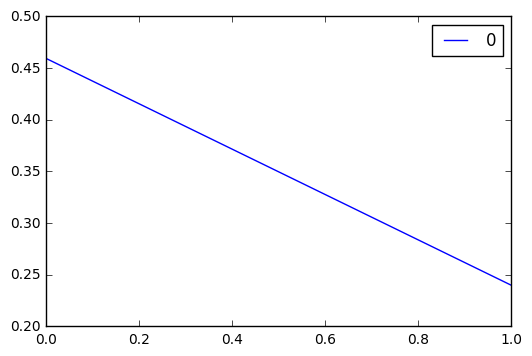

In [15]:
## Plot Training Results:
a = pd.DataFrame(training_losses)
print("Epoch vs Training Losses")
plt.show(a.plot())

### Generating

In [18]:
## Evaluating Network

batch_size = 1
num_steps = 1

## Reload the graph
## Training Network
reset_graph()
graph = tf.get_default_graph()
with graph.as_default():
    x = tf.placeholder(tf.int32,[batch_size,num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32,[batch_size,num_steps], name='labels_placeholder')
    embeddings = tf.get_variable('embedding_matrix', [num_input_classes, num_nodes])
    out_embedding = tf.get_variable('out_emedding_matrix',[num_output_classes,num_nodes])
    rnn_inputs = tf.nn.embedding_lookup(embeddings,x)
    
    # Define the network
    cell = tf.nn.rnn_cell.LSTMCell(num_nodes,state_is_tuple=True)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
    init_state = cell.zero_state(batch_size,tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

    with tf.variable_scope('softmax'):
        W = tf.get_variable('W',[num_nodes,num_output_classes])
        b = tf.get_variable('b',[num_output_classes], initializer=tf.constant_initializer(0.0))
    
    rnn_outputs = tf.reshape(rnn_outputs,[-1,num_nodes])
    y_reshaped = tf.reshape(y,[-1])
    logits = tf.matmul(rnn_outputs, W) + b
    predictions = tf.nn.softmax(logits)

    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    saver = tf.train.Saver()
    print("Graph Specs:")
    print("Num Input Classes: " + str(num_input_classes))
    print("Num Output Classes: " + str(num_output_classes))
    print("Inputs: " + str(rnn_inputs))
    print("Outputs: " + str(rnn_outputs))
    print("Logits: " + str(logits))
    print("Predictions: " + str(predictions))
    
def plot_gesture_only_score(plot_title, gestures):
    """
    Plots a gesture score of gestures only - no new ideas!
    """
    idx = gestures.index
    plt.style.use('ggplot')
    ax = plt.figure(figsize=(14, 4), frameon=False, tight_layout=True).add_subplot(111)
    ax.yaxis.grid()
    plt.ylim(-0.5, 8.5)
    plt.yticks(np.arange(9), ['n', 'ft', 'st', 'fs', 'fsa', 'vss', 'bs', 'ss', 'c'])
    for n in gestures.columns:
        plt.plot(gestures.index, gestures[n], '-', label=n)
    #plt.savefig(plot_title.replace(":", "_") + '.pdf', dpi=150, format="pdf")
    #plt.close()
    plt.show()

Graph Specs:
Num Input Classes: 81
Num Output Classes: 9
Inputs: Tensor("embedding_lookup:0", shape=(1, 1, 512), dtype=float32)
Outputs: Tensor("Reshape:0", shape=(1, 512), dtype=float32)
Logits: Tensor("add:0", shape=(1, 9), dtype=float32)
Predictions: Tensor("Softmax:0", shape=(1, 9), dtype=float32)


dual-player-lstm-model-512nodes-2-epochs.tfsave


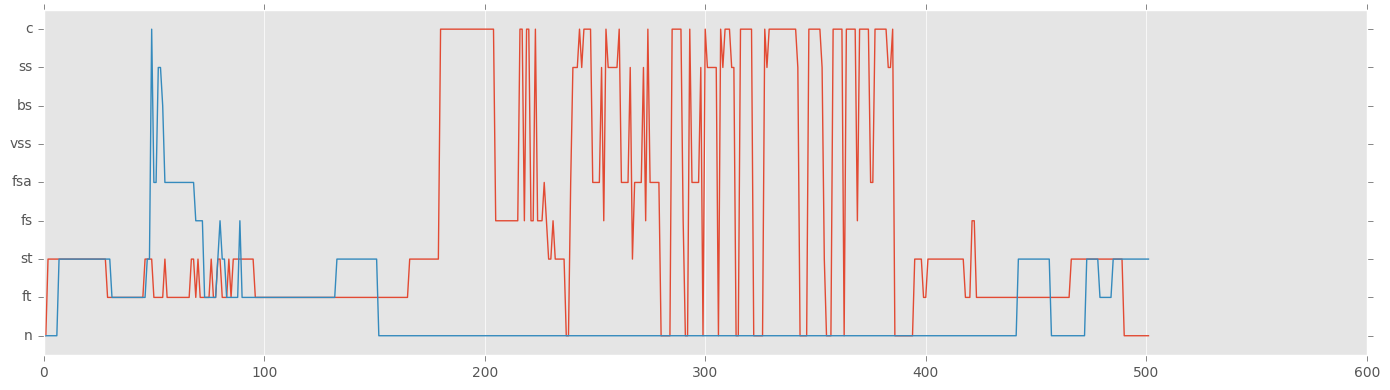

In [44]:
num_gen_steps = 443
num_performances = 1
generated_performance = pd.DataFrame()
player_one = random.choice(individual_improvisations)
generated_performance["player1"] = player_one
player_one = player_one.tolist()
print(model_name)

with tf.Session() as sess:
    # possibly restore all variables
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, "./"+model_name)
    
    # start generating output
    state = None
    output_perf = []
    last_pred = 0 # initial state for the alternate player
    
    for current_step in player_one:
        if state is not None:
            feed_dict = {x: [[encode_ensemble_gestures((current_step,last_pred))]], init_state: state}
        else:
            feed_dict = {x: [[encode_ensemble_gestures((current_step,last_pred))]]}
        preds,state = sess.run([predictions,final_state],feed_dict=feed_dict)
        last_pred = np.random.choice(vocabulary_size,1,p=np.squeeze(preds))[0] # choose the output step
        output_perf.append(last_pred)
generated_performance['generated_player'] = np.array(output_perf)

#generated_performance.to_csv("100epoch-ensemble-performances")   
plot_gesture_only_score("100 epochs", generated_performance)

In [87]:
generated_performance.to_csv(mode_name + "-generated-perf.csv")
